<a href="https://colab.research.google.com/github/Lwee-Ahn/Image-Segmentaion-with-U_Net/blob/main/Image_Segmentation_with_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose,concatenate
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load and Split the Data

In [ ]:
path = ''

image_path = os.path.join(path,'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraRGB/')
mask_path = os.path.join(path, '/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraMask/')

image_list_orig = os.listdir(image_path)

image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

<ipython-input-16-06c20e640ce4>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-16-06c20e640ce4>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

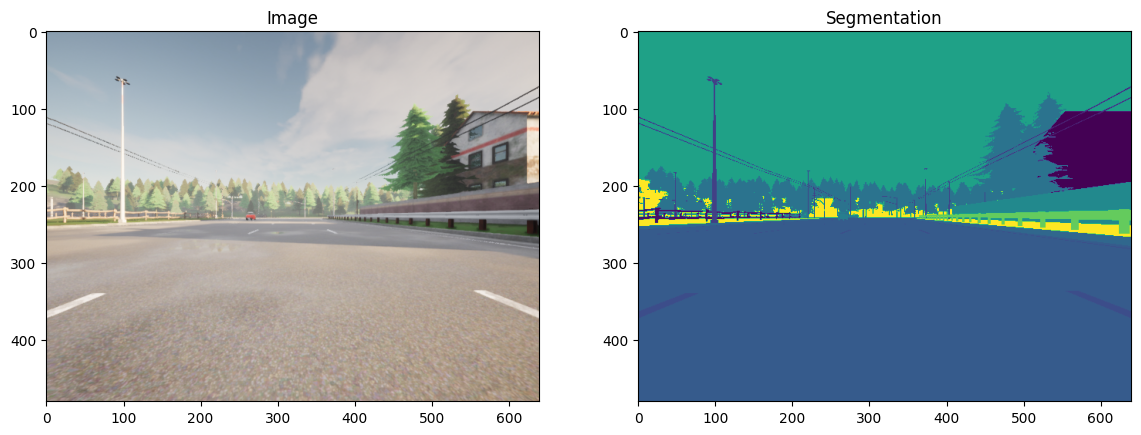

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

#Split Dataset into Unmasked and Masked Images

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3),mask_list_ds.take(3)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraMask/000028.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames,mask_filenames))

for image,mask in dataset.take(1):
  print(image)
  print(mask)

tf.Tensor(b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraRGB/002122.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/ImageSegmentationwithUnet/data/CameraMask/002122.png', shape=(), dtype=string)


#Data Preprocessing

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

#U-Net

## Encoder(Downsampling Block)

In [ ]:
def conv_block(inputs = None,n_filters = 32, dropout_prob=0, max_pooling=True):

  """
  Convolutional downsampling block

  Arguments :
    inputs -- Input Tensor
    n_filters -- Number of filters for convolutional layer
    dropout_prob -- Dropout probability
    max_pooling -- Use Maxpooling2D

  Returns:
    next_layers, skip_connection -- Next layer and skip connection

  """


  conv = Conv2D(n_filters,3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
  conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  if max_pooling:
    next_layer = MaxPooling2D((2,2))(conv)

  else:
    next_layer = conv

  skip_connection = conv

  return next_layer,skip_connection

##Decoder (Upsampling block)

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filter=32):
  """
  Convolutional upsampling block

  Arguments :
    expansive_input -- Input tensor from previous layer
    contractive_input -- Input tensor from previous skip layer
    n_filters -- Number of filters for the convolutional layer

  Returns:
    conv -- Tensor output

  """

  up =  Conv2DTranspose(n_filter, 3, strides=2,padding='same')(expansive_input)

  # Merge the previous output and the contractive_input
  merge = concatenate([up,contractive_input], axis = 3)
  conv = Conv2D(n_filter, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
  conv = Conv2D(n_filter, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

  return conv


#Modeling

## U-Net Model

In [ ]:
def unet_model(input_size=(96,128,3), n_filters=32, n_classes = 23):
  """

  Unet model

  Arguments:
    input_size -- Input shape
    n_filters -- Number of filters for the convolutional layer
    n_classes -- Number of output classes

  Returns:
    model -- tf.keras.Model

  """
  inputs = Input(input_size)
  #Contracting Path(encoding)
  cblock1 = conv_block(inputs, n_filters)
  cblock2 = conv_block(cblock1[0], n_filters*2)
  cblock3 = conv_block(cblock2[0], n_filters*4)
  cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
  cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

  #Expanding Path(decoding)
  ublock6 = upsampling_block(cblock5[0],cblock4[1], n_filters*8)
  ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
  ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
  ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

  conv9 = Conv2D(n_filters,3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)

  conv10 = Conv2D(n_classes,1,padding='same')(conv9)

  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model


In [ ]:
img_height=96
img_width = 128
num_channels = 3

unet=unet_model((img_height,img_width,num_channels))

In [ ]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 96, 128, 32)          896       ['input_3[0][0]']             
                                                                                                  
 conv2d_41 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_40[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_41[0][0]']           
 g2D)                                                                                       

In [ ]:
unet.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [ ]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image','True Mask','Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(480, 640, 1)


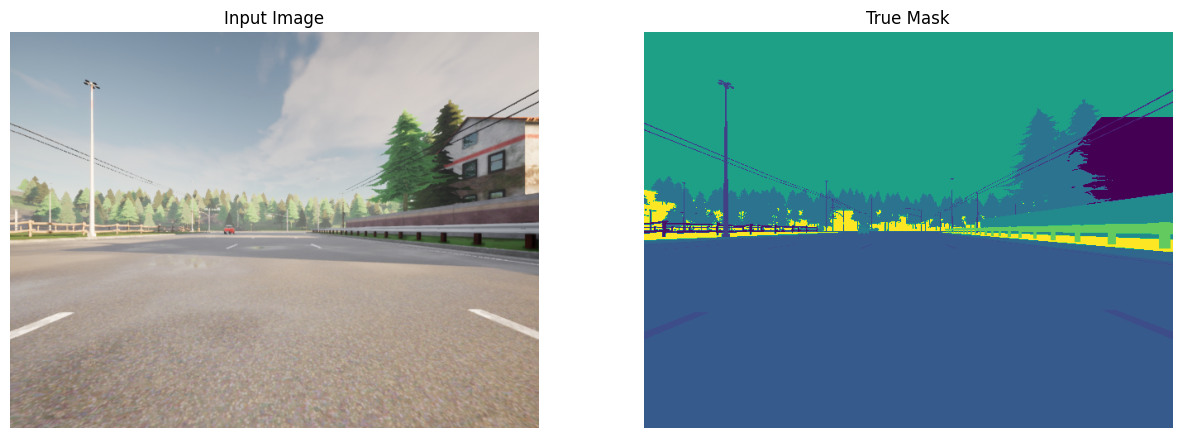

In [ ]:
for image,mask in image_ds.take(1):
  sample_image,sample_mask = image,mask
  print(mask.shape)
display([sample_image,sample_mask])

#Model Training

In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 571s 12s/step - loss: 1.8134 - accuracy: 0.4874
Epoch 2/5
34/34 [==============================] - 406s 12s/step - loss: 0.9902 - accuracy: 0.7481
Epoch 3/5
34/34 [==============================] - 402s 12s/step - loss: 0.6374 - accuracy: 0.8203
Epoch 4/5
34/34 [==============================] - 407s 12s/step - loss: 0.5139 - accuracy: 0.8445
Epoch 5/5
34/34 [==============================] - 408s 12s/step - loss: 0.4293 - accuracy: 0.8716


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[...,tf.newaxis]
  return pred_mask[0]

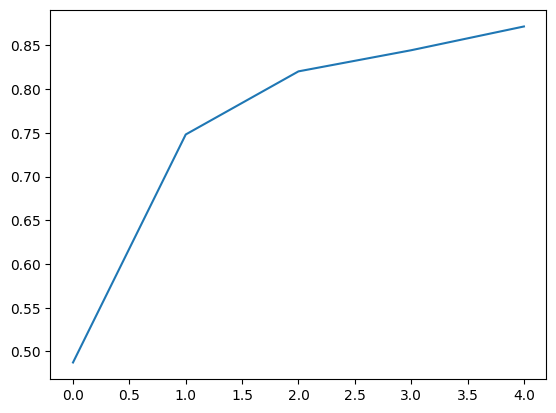

In [ ]:
plt.plot(model_history.history['accuracy'])

In [ ]:
def show_prediction(dataset=None, num=1):
  if dataset:
    for image,mask in dataset.take(num):
      pred_mask = unet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image,sample_mask,create_mask(unet.predict(sample_image[tf.newaxis,...]))])

1/1 [==============================] - 6s 6s/step


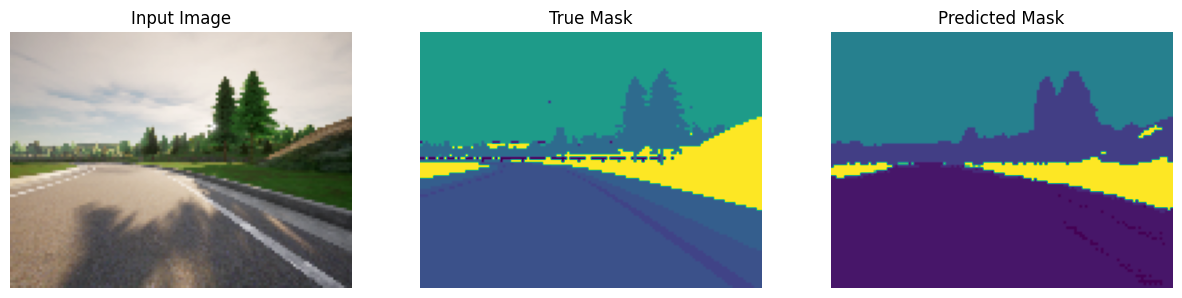

1/1 [==============================] - 3s 3s/step


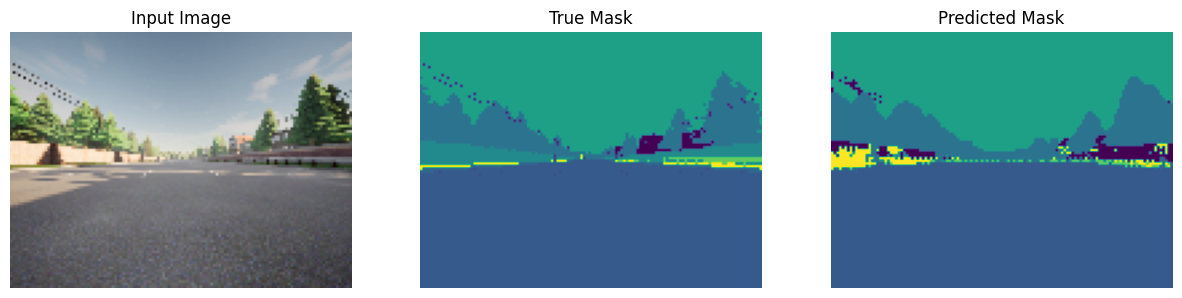

1/1 [==============================] - 3s 3s/step


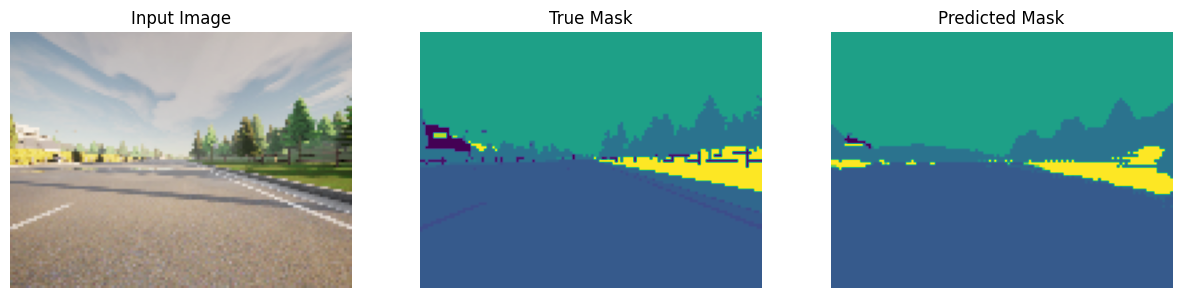

1/1 [==============================] - 3s 3s/step


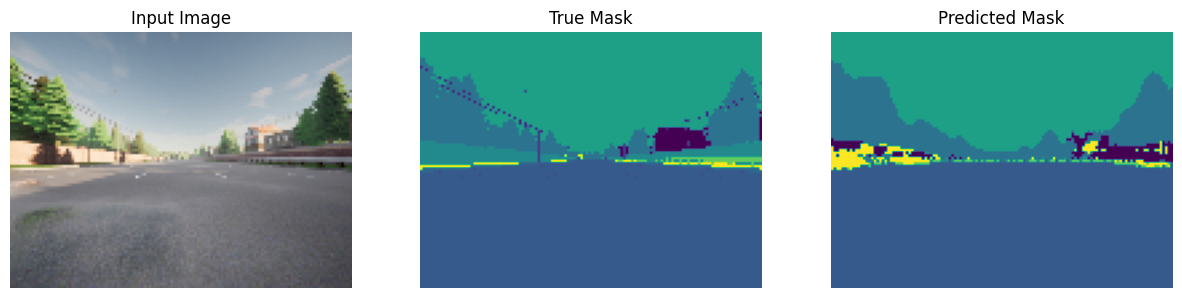

1/1 [==============================] - 3s 3s/step


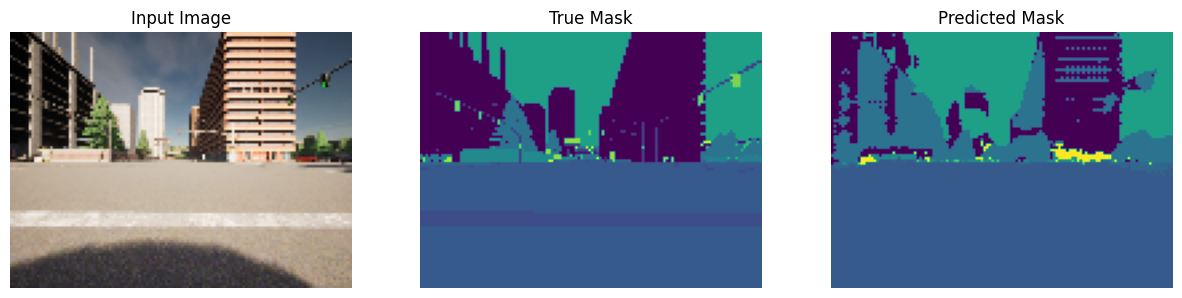

1/1 [==============================] - 4s 4s/step


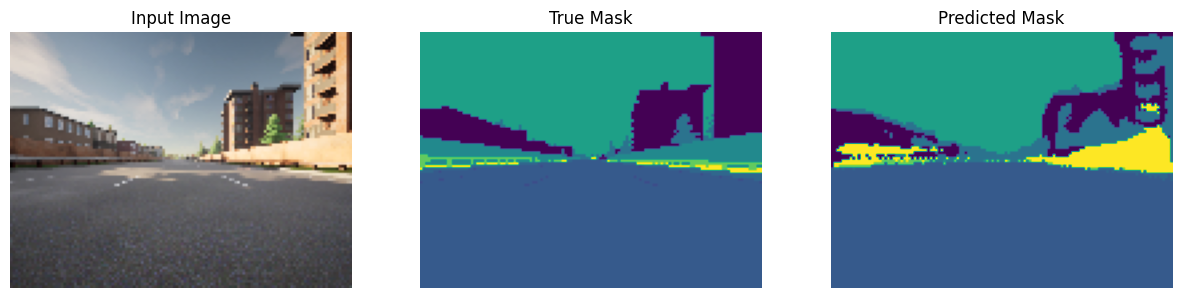

In [ ]:
show_prediction(train_dataset,6)